## **Calculate Scaling Rate**

### **Import libraries**

In [38]:
import pandas as pd 
import numpy as np 
import xarray as xr

### **Create a list of year**

In [39]:
years_list = [str(year) for year in range(2051, 2091)]
print(years_list)

['2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058', '2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067', '2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076', '2077', '2078', '2079', '2080', '2081', '2082', '2083', '2084', '2085', '2086', '2087', '2088', '2089', '2090']


### **Read the interpolated data and turn it to dictionary with each year as key and store values as dataframe**

In [40]:
interp_pr = {}
for year in years_list:
    file_name = f"{year}.csv"
    interp_pr[year] = pd.read_csv("D:\Min\Review GCM\FGOALS\SSP585\Pr\Interpolated\\" + file_name)

In [41]:
for key, df in interp_pr.items():
    df = df[df.lat > -60]
    df = df.reset_index(drop = True)
    interp_pr[key] = df 

In [42]:
interp_tas  = {}
for year in years_list:
    file_name = f"{year}.csv"
    interp_tas[year] = pd.read_csv("D:\Min\Review GCM\FGOALS\SSP585\Tas\Interpolated\\" + file_name)

In [43]:
for key, df in interp_tas.items():
    df = df[df.lat > -60]
    df = df.reset_index(drop = True)
    interp_tas[key] = df 

In [44]:
interp_hur  = {}
for year in years_list:
    file_name = f"{year}.csv"
    interp_hur[year] = pd.read_csv("D:\Min\Review GCM\FGOALS\SSP585\Hur\Interpolated\\" + file_name)

In [45]:
for key, df in interp_hur.items():
    df = df[df.lat > -60]
    df = df.reset_index(drop = True)
    interp_hur[key] = df 

### **Calculate Dewpoint Temperature**

In [46]:
def calculate_dewpoint(temp, humidity):
    A = 17.27
    B = 237.7
    alpha = ((A * temp) / (B + temp)) + np.log(humidity/100.0)
    return (B * alpha) / (A - alpha)

In [47]:
import warnings
warnings.filterwarnings(action='ignore')

In [48]:
interp_tdew = {}

for key in interp_tas.keys():
    tas = interp_tas[key]
    hur = interp_hur[key]
    tdew = pd.DataFrame()  
    tdew[["lat", 'lon']] = tas[["lat", 'lon']]  
    for day in tas.columns[2:]:  
        tdew[day] = calculate_dewpoint(tas[day], hur[day])
    interp_tdew[key] = tdew

### **Combine Precipitation and Tdew**

In [49]:
data = interp_pr.copy()

In [50]:
data_t = interp_tdew.copy()

In [51]:
pr = list(interp_pr.values())
pr = pd.concat([df.set_index(['lat', 'lon']) for df in pr], axis=1).reset_index()

In [52]:
pr['lat_lon'] = pr['lat'].astype(str) + ',' + pr['lon'].astype(str)
pr = pr.drop(['lat', 'lon'], axis=1)

In [53]:
pr_long = pd.melt(pr, id_vars=['lat_lon'], var_name='date', value_name='pr')

In [54]:
tdew = list(interp_tdew.values())
tdew  = pd.concat([df.set_index(['lat', 'lon']) for df in tdew], axis=1).reset_index()

In [55]:
tdew['lat_lon'] = tdew['lat'].astype(str) + ',' +  tdew['lon'].astype(str)
tdew = tdew.drop(['lat', 'lon'], axis=1)

In [56]:
tdew_long = pd.melt(tdew, id_vars=['lat_lon'], var_name='date', value_name='tdew')

In [57]:
pr_long["tdew"] = tdew_long['tdew'].values

### **Selecting only wet day**

In [58]:
pr_long = pr_long[pr_long.pr > 1]

### **Quantile Regression**

In [59]:
import statsmodels.api as sm
result = pr_long.groupby('lat_lon').apply(lambda group: sm.QuantReg(np.log(group['pr']), sm.add_constant(group[['tdew']])).fit(q=0.99))

#### **Turn results into dataframe and select identify slope from quantile regression**

In [60]:
dfs = []
for group_key, group_result in result.items():
    lat_lon = group_key
    slope_coefficient = group_result.params['tdew']  
    df = pd.DataFrame({'lat_lon': [lat_lon], 'slope_coefficient': [slope_coefficient]})
    dfs.append(df)

coefficients_df = pd.concat(dfs, ignore_index=True)

#### **Calculate scaling rate**

$100(e^\alpha -1 )$

In [61]:
coefficients_df["Scaling"] = 100*(np.e**coefficients_df["slope_coefficient"] - 1)

In [62]:
coefficients_df[['lat', 'lon']] = coefficients_df['lat_lon'].str.split(',', expand=True)

coefficients_df['lat'] = pd.to_numeric(coefficients_df['lat'])
coefficients_df['lon'] = pd.to_numeric(coefficients_df['lon'])

df = coefficients_df.drop('lat_lon', axis=1)

#### **Visualize the result**

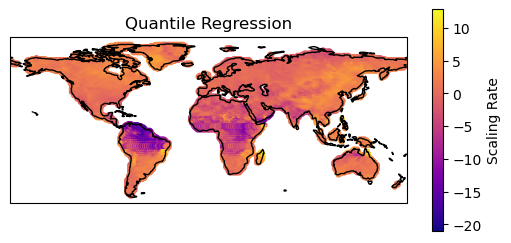

In [63]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

lons = df['lon'].values
lats = df['lat'].values
precipitation = df["Scaling"].values

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

num_colors = 1000

cmap = plt.get_cmap('plasma', num_colors)

norm = plt.Normalize(precipitation.min(), precipitation.max())
sc = ax.scatter(lons, lats, c=precipitation, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, orientation='vertical', label='Scaling Rate')

ax.coastlines()
#ax.gridlines()
plt.title("Quantile Regression")
# Show the plot
plt.show()


#### **Save the result**

In [64]:
coefficients_df.to_csv("Quantile Regression.csv")

### **Binning Methods Equal Data Point**

In [65]:
df = pr_long.copy()

#### **Turn data to 20 bins with equal sample size**

In [66]:
n_bins = 20

df['bin'] = df.groupby('lat_lon')['tdew'].transform(lambda x: pd.qcut(x, q=n_bins, labels=False, duplicates='drop'))

In [67]:
dfs = df.drop(['date'], axis = 1)

#### **Select only 99 percentile of each bin and its avergae temperature, also calculate the log(p99)**

In [68]:
result = dfs.groupby(['lat_lon', 'bin']).agg({'pr': lambda x: x.quantile(0.99), 'tdew': 'mean'}).reset_index()
result['log_p_99'] = result['pr'].apply(lambda x: 0 if x <= 0 else 1 if x == 1 else np.log(x))

In [69]:
result.columns = ['lat_lon', 'bin', 'p_99_pr', 'mean_tdew', 'log_p99']

### **Linear model**

$log(P99) = \alpha Tdew + \beta$


In [70]:
from scipy.stats import linregress

In [71]:
slopes = []

for lat_lon, group in result.groupby('lat_lon'):

    slope, _, _, _, _ = linregress(group['mean_tdew'], group['log_p99'])

    slopes.append({'lat_lon': lat_lon, 'slope': slope})

slope_df = pd.DataFrame(slopes)

#### **Calculate scaling**
$100(e^\alpha -1 )$

In [72]:
slope_df["Scaling"] = 100*(np.e**slope_df["slope"] - 1)

In [73]:
slope_df[['lat', 'lon']] = slope_df['lat_lon'].str.split(',', expand=True)

slope_df['lat'] = pd.to_numeric(slope_df['lat'])
slope_df['lon'] = pd.to_numeric(slope_df['lon'])

slope_df = slope_df.drop('lat_lon', axis=1)

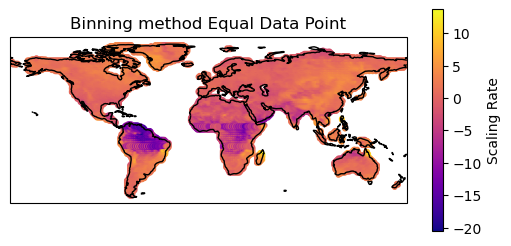

In [74]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

lons = slope_df['lon'].values
lats = slope_df['lat'].values
precipitation = slope_df["Scaling"].values

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

num_colors = 1000

cmap = plt.get_cmap('plasma', num_colors)

norm = plt.Normalize(precipitation.min(), precipitation.max())
sc = ax.scatter(lons, lats, c=precipitation, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, orientation='vertical', label='Scaling Rate')

ax.coastlines()
#ax.gridlines()
plt.title("Binning method Equal Data Point")
# Show the plot
plt.show()


#### **Save the result**

In [75]:
slope_df.to_csv("Binning Method (Equal Data Point).csv")

### **Equal Bin Width**

In [76]:
df = pr_long.copy()

In [77]:
bin_width = 1

def calculate_bins(series):
    series_range = series.max() - series.min()
    return int(series_range / bin_width)

df['bin'] = df.groupby('lat_lon')['tdew'].transform(lambda x: pd.cut(x, bins=calculate_bins(x), labels=False, include_lowest=True))

In [78]:
df

,lat_lon,date,pr,tdew,bin
31,"40.0,0.0",2051-01-01 12:00:00,7.306230,-7.888423,29
32,"41.0,0.0",2051-01-01 12:00:00,8.616739,-9.252419,29
33,"42.0,0.0",2051-01-01 12:00:00,8.480399,-9.423529,30
34,"43.0,0.0",2051-01-01 12:00:00,6.729686,-11.784964,30
35,"44.0,0.0",2051-01-01 12:00:00,6.434341,-12.232869,30
...,...,...,...,...,...
219029191,"42.0,360.0",2090-12-31 12:00:00,1.023202,-20.999234,15
219029196,"53.0,360.0",2090-12-31 12:00:00,1.074159,-11.576299,31
219029197,"54.0,360.0",2090-12-31 12:00:00,2.140498,-10.268536,33
219029198,"55.0,360.0",2090-12-31 12:00:00,3.162778,-10.121776,32


In [79]:
dfs = df.drop(['date'], axis = 1)

#### **Select only 99 percentile of each bin and its avergae temperature, also calculate the log(p99)**

In [80]:
result = dfs.groupby(['lat_lon', 'bin']).agg({'pr': lambda x: x.quantile(0.99), 'tdew': 'mean'}).reset_index()
result['log_p_99'] = result['pr'].apply(lambda x: 0 if x <= 0 else 1 if x == 1 else np.log(x))

In [81]:
result.columns = ['lat_lon', 'bin', 'p_99_pr', 'mean_tdew', 'log_p99']

### **Linear model**

$log(P99) = \alpha Tdew + \beta$


In [82]:
from scipy.stats import linregress

In [83]:
slopes = []

for lat_lon, group in result.groupby('lat_lon'):

    slope, _, _, _, _ = linregress(group['mean_tdew'], group['log_p99'])

    slopes.append({'lat_lon': lat_lon, 'slope': slope})

slope_df = pd.DataFrame(slopes)

#### **Calculate scaling**
$100(e^\alpha -1 )$

In [84]:
slope_df["Scaling"] = 100*(np.e**slope_df["slope"] - 1)

In [85]:
slope_df[['lat', 'lon']] = slope_df['lat_lon'].str.split(',', expand=True)

slope_df['lat'] = pd.to_numeric(slope_df['lat'])
slope_df['lon'] = pd.to_numeric(slope_df['lon'])

slope_df = slope_df.drop('lat_lon', axis=1)

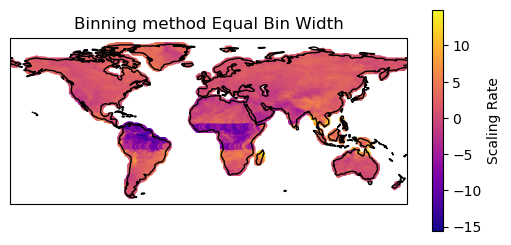

In [87]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

lons = slope_df['lon'].values
lats = slope_df['lat'].values
precipitation = slope_df["Scaling"].values

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

num_colors = 1000

cmap = plt.get_cmap('plasma', num_colors)

norm = plt.Normalize(precipitation.min(), precipitation.max())
sc = ax.scatter(lons, lats, c=precipitation, cmap=cmap, norm=norm, s=10)
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, orientation='vertical', label='Scaling Rate')

ax.coastlines()
#ax.gridlines()
plt.title("Binning method Equal Bin Width")
# Show the plot
plt.show()
